In [1]:
%matplotlib inline

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [3]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mock.Lbox = 500.

#  Bpl-based mock
# dirname = "/Users/aphearin/work/random/0331"
# basename = "testing_bpl_based_v4.hdf5"
# fname = os.path.join(dirname, basename)
# mock = Table.read(fname, path='data')
# mock.Lbox = 250.

print(mock.keys())

['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile']


## Map $M_{\rm r}$ onto every galaxy based on its $M_{\ast}$ 

In [4]:
from cosmodc2.sdss_colors import mock_magr

mock['restframe_extincted_sdss_abs_magr'] = mock_magr(
            mock['upid'], mock['obs_sm'], mock['sfr_percentile'], 
            mock['host_halo_mvir'], sdss['sm'], sdss['sfr_percentile_fixed_sm'], 
            sdss['restframe_extincted_sdss_abs_magr'], sdss['z'])


## Map ${\rm g-r}$ and ${\rm r-i}$ onto every galaxy 

In [5]:
from cosmodc2.sdss_colors import gr_ri_monte_carlo, overhaul_gr_ri_monte_carlo

magr = mock['restframe_extincted_sdss_abs_magr'] 
percentile = mock['sfr_percentile']
redshift = np.zeros_like(magr)

gr, ri, is_red_ri, is_red_gr = overhaul_gr_ri_monte_carlo(
    magr, percentile, redshift, local_random_scale=0.1, nonlocal_random_fraction=0.05)

mock['gr'] = gr
mock['ri'] = ri
mock['is_red_ri'] = is_red_ri
mock['is_red_gr'] = is_red_gr

In [6]:
from cosmodc2.sdss_colors import remap_cluster_bcg_gr_ri_color

gr_remapped, ri_remapped = remap_cluster_bcg_gr_ri_color(mock['upid'], mock['host_halo_mvir'], 
                              np.copy(mock['gr']), np.copy(mock['ri']))

mock['_gr_no_remap'] = np.copy(mock['gr'])
mock['_ri_no_remap'] = np.copy(mock['ri'])
mock['gr'] = gr_remapped
mock['ri'] = ri_remapped

## Inspect cluster halo colors

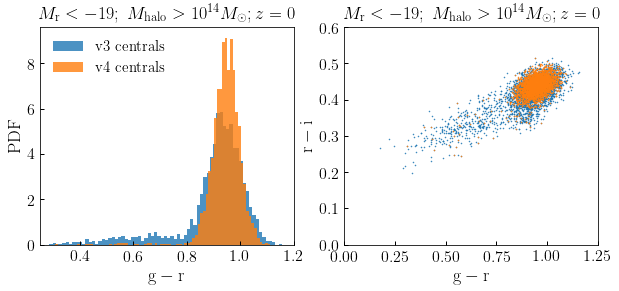

In [7]:
magr_mask = mock['restframe_extincted_sdss_abs_magr'] < -19
cenmask = mock['upid'] == -1
cluster_halo_mask = mock['host_halo_mvir'] > 10**14


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

nbins = 80
__=ax1.hist(mock['_gr_no_remap'][cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm v3\ centrals}$')
__=ax1.hist(mock['gr'][cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm v4\ centrals}$')

legend = ax1.legend()
xlim1 = ax1.set_xlim(0.25, 1.2)
xlabel1 = ax1.set_xlabel(r'${\rm g-r}$')
ylabel1 = ax1.set_ylabel(r'${\rm PDF}$')
_title = r'$M_{\rm r} < -19;\ M_{\rm halo}>10^{14}M_{\odot}; z=0$'
title1 = ax1.set_title(_title)


__=ax2.scatter(mock['_gr_no_remap'][cenmask & cluster_halo_mask & magr_mask],
              mock['_ri_no_remap'][cenmask & cluster_halo_mask & magr_mask], s=0.25, 
              label=r'${\rm v3\ centrals}$')

__=ax2.scatter(mock['gr'][cenmask & cluster_halo_mask & magr_mask],
              mock['ri'][cenmask & cluster_halo_mask & magr_mask], s=0.25, 
              label=r'${\rm v4\ centrals}$')

xlim2 = ax2.set_xlim(0., 1.25)
ylim2 = ax2.set_ylim(0., 0.6)
xlabel2 = ax2.set_xlabel(r'${\rm g-r}$')
ylabel2 = ax2.set_ylabel(r'${\rm r-i}$')
_title = r'$M_{\rm r} < -19;\ M_{\rm halo}>10^{14}M_{\odot}; z=0$'
title2 = ax2.set_title(_title)

figname = 'central_colors_v3_vs_v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')

## Compare color-dependent clustering to Zehavi+11

In [12]:
from cosmodc2.sdss_colors import zehavi11_clustering
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi

wp_blue18p5, wperr_blue18p5 = zehavi11_clustering(-18.5, subsample='blue')
wp_red18p5, wperr_red18p5 = zehavi11_clustering(-18.5, subsample='red')

wp_blue19p0, wperr_blue19p0 = zehavi11_clustering(-19, subsample='blue')
wp_red19p0, wperr_red19p0 = zehavi11_clustering(-19, subsample='red')

wp_blue19p5, wperr_blue19p5 = zehavi11_clustering(-19.5, subsample='blue')
wp_red19p5, wperr_red19p5 = zehavi11_clustering(-19.5, subsample='red')

wp_blue20p0, wperr_blue20p0 = zehavi11_clustering(-20, subsample='blue')
wp_red20p0, wperr_red20p0 = zehavi11_clustering(-20, subsample='red')

wp_blue20p5, wperr_blue20p5 = zehavi11_clustering(-20.5, subsample='blue')
wp_red20p5, wperr_red20p5 = zehavi11_clustering(-20.5, subsample='red')

wp_blue21p5, wperr_blue21p5 = zehavi11_clustering(-21.5, subsample='blue')
wp_red21p5, wperr_red21p5 = zehavi11_clustering(-21.5, subsample='red')


In [13]:
from cosmodc2.mock_diagnostics import zehavi_wp

protoDC2_littleh = 0.7

period = mock.Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['restframe_extincted_sdss_abs_magr']

rp_mids, wp_v4_18p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -18.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['gr'])

rp_mids, wp_v4_18p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -18.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['gr'])

rp_mids, wp_v4_19p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['gr'])

rp_mids, wp_v4_19p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['gr'])

rp_mids, wp_v4_19p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['gr'])

rp_mids, wp_v4_19p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['gr'])

rp_mids, wp_v4_20p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['gr'])

rp_mids, wp_v4_20p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['gr'])

rp_mids, wp_v4_21p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['gr'])

rp_mids, wp_v4_21p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['gr'])


...calculating wp for 3.99e+05 galaxies and Mr < -18.5
...calculating wp for 4.00e+05 galaxies and Mr < -18.5
...calculating wp for 3.99e+05 galaxies and Mr < -19.0
...calculating wp for 4.00e+05 galaxies and Mr < -19.0
...calculating wp for 4.01e+05 galaxies and Mr < -19.5
...calculating wp for 4.00e+05 galaxies and Mr < -19.5
...calculating wp for 1.68e+05 galaxies and Mr < -20.5
...calculating wp for 2.49e+05 galaxies and Mr < -20.5
...calculating wp for 9.59e+03 galaxies and Mr < -21.5
...calculating wp for 3.70e+04 galaxies and Mr < -21.5


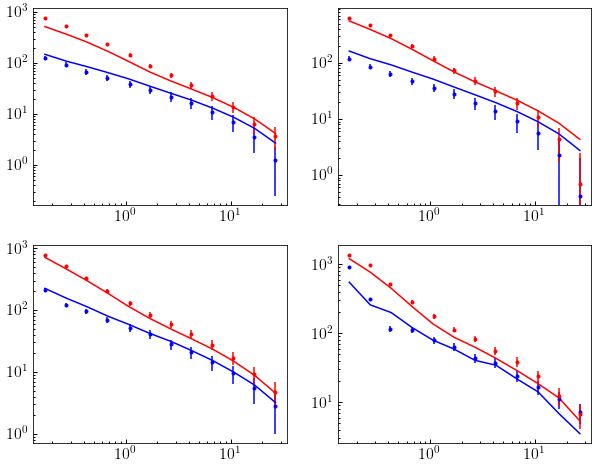

In [14]:
fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()

__=ax1.errorbar(rp_zehavi, wp_blue19p0, np.sqrt(wperr_blue19p0), fmt='.', color='blue')
__=ax1.errorbar(rp_zehavi, wp_red19p0, np.sqrt(wperr_red19p0), fmt='.', color='red')
__=ax1.plot(rp_mids, wp_v4_19p0_blue, color='blue')
__=ax1.plot(rp_mids, wp_v4_19p0_red, color='red')

__=ax2.errorbar(rp_zehavi, wp_blue19p5, np.sqrt(wperr_blue19p5), fmt='.', color='blue')
__=ax2.errorbar(rp_zehavi, wp_red19p5, np.sqrt(wperr_red19p5), fmt='.', color='red')
__=ax2.plot(rp_mids, wp_v4_19p5_blue, color='blue')
__=ax2.plot(rp_mids, wp_v4_19p5_red, color='red')

__=ax3.errorbar(rp_zehavi, wp_blue20p5, np.sqrt(wperr_blue20p5), fmt='.', color='blue')
__=ax3.errorbar(rp_zehavi, wp_red20p5, np.sqrt(wperr_red20p5), fmt='.', color='red')
__=ax3.plot(rp_mids, wp_v4_20p5_blue, color='blue')
__=ax3.plot(rp_mids, wp_v4_20p5_red, color='red')

__=ax4.errorbar(rp_zehavi, wp_blue21p5, np.sqrt(wperr_blue21p5), fmt='.', color='blue')
__=ax4.errorbar(rp_zehavi, wp_red21p5, np.sqrt(wperr_red21p5), fmt='.', color='red')
__=ax4.plot(rp_mids, wp_v4_21p5_blue, color='blue')
__=ax4.plot(rp_mids, wp_v4_21p5_red, color='red')


